# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Davis | Dickson | Davis Dickson | Hours | 25% |
| Member 2: | Shichuang | Nie | Shichuang Nie | 3 Hours | 25% |
| Member 3: | First Name | Last Name | Signature | Hours | 25% |
| Member 4: | First Name | Last Name | Signature | Hours | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

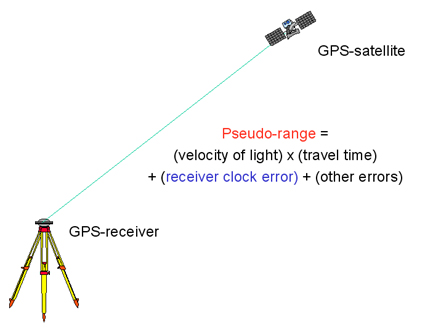

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

In [55]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/engg680_2024_fall/Lab_Assignment3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/engg680_2024_fall/Lab_Assignment3'
/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


Step 0.1: Import necessary libraries

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [59]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos = df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

print('pseudorange', pseudorange)
print('sat_pos', sat_pos)



pseudorange [22919740.9614295 20459894.0877988 22400338.4134134 22829140.9126004
 22342014.8171753 25646454.5362932 23814776.2454228 24311399.3171521
 21353640.1406793 24971609.6374347 20638981.0590005]
sat_pos [[  5280791.73836563 -25501460.1192133    4649508.28809917]
 [ -2159656.05205653 -21116024.7920163   15597909.1971221 ]
 [ 10371852.1682927  -21713111.3497771   10558686.998121  ]
 [-16085760.7811889    4285071.21612309  20742042.1246963 ]
 [-14312988.0806279  -22045014.2659254    4671208.3988653 ]
 [ -2435718.18737303  16257205.12951     21099779.5379103 ]
 [ 15912467.1868696   -3462515.31492602  21053628.253335  ]
 [ 16271848.163885     -218766.32031082  21035332.7037679 ]
 [-19247035.5286677   -7259803.67892242  16472981.9071979 ]
 [-15931152.0364578   12077367.2515846   18058076.7648504 ]
 [ -7680014.10843999 -13855462.7231353   21842975.3728112 ]]


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [61]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [96]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [63]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.sqrt(np.sum((satellite_pos - receiver_pos)**2))

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [64]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

  P = np.zeros(n) # n satellites, n O
  for i in range(n):
    P[i] = euclidean_norm(r_pos, s_pos[i]) - cdT # measured pseudoranges

  L = np.sum((pseudorange - P)**2) # sum of squared residuals between measured and predicted pseudoranges
  return L


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [69]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    grad = np.zeros(4) # initialize to store component for each unknown, x_r, y_r, z_r, and cdT
    distances = np.zeros(n) # n satellites, need n distances from receiver

    for i in range(n):
      distances[i] = euclidean_norm(r_pos, s_pos[i]) # get geometric distance from each satellite

# calculate derivative with respect to unknown receiver coordinates for each component
    for i in range(3):
      grad[i] = 2/n * np.sum((distances - pseudorange + cdT)*(r_pos[i] - s_pos[:,i]) / distances)

# calculate derivative with respect to unknown receiver clock offset
    grad[3] = 2/n * np.sum(distances - pseudorange + cdT) # derivative with respect to cdT

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [89]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count
    steps_count = 0

    #initalize the estimates as zeros
    X = np.zeros(4)

    cost_arr = np.array([])


    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)


        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)


        # break the loop if converge
        if np.abs(current_cost - new_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new
        steps_count+=1

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [97]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics

print(optimized_params)
print(arr_err[-1])
print(steps_count)
print(arr_cost[-1])
print(arr_grad[-1])

Converged !
[-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46482723e+00]
[-3.06409938 -2.35575124  3.80048268]
3150
6.197103245713623
[ 4.72685147e-05  2.63377571e-04 -8.09468114e-04 -4.58909708e-04]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

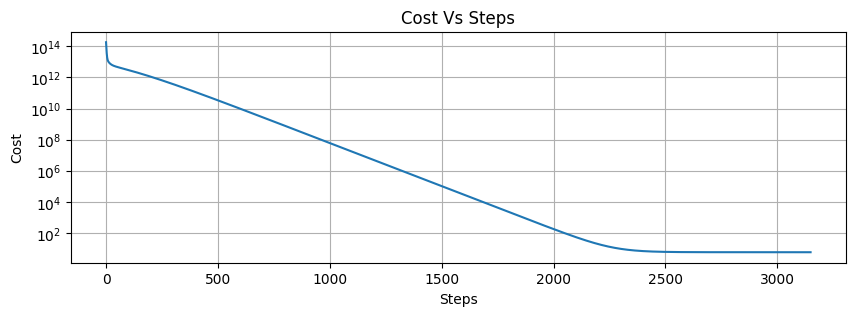

In [102]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.semilogy(arr_cost)
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Cost Vs Steps")
ax.grid(True)
#fig.tight_layout()
plt.show()

# Comment on the pattern
# As the training progresses, the loss decreases significantly during the initial epochs, followed by a smoother decline.
# The downward trend stabilizes around 2250 epochs.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

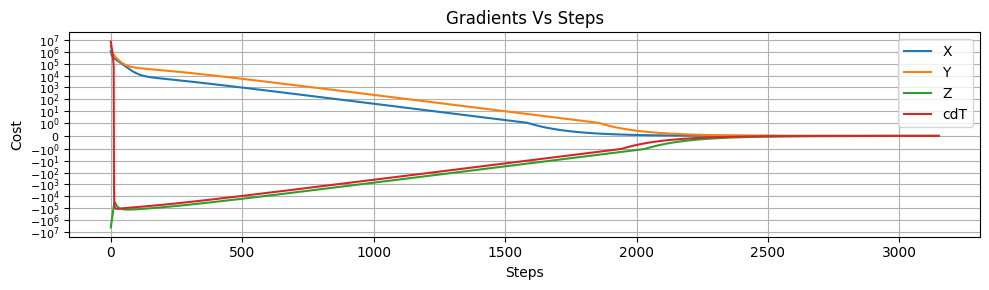

In [110]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...

# Plot each gradient with a label
ax.plot(arr_grad[:], label=["X","Y","Z","cdT"])


# Set the y-axis to a symmetric logarithmic scale
ax.set_yscale('symlog', linthresh=1)
ax.set_xlabel("Steps", fontsize=10)
ax.set_ylabel("Gradients", fontsize=10)
ax.set_title("Gradients Vs Steps", fontsize=12)

# Customize the tick parameters on the y-axis
ax.tick_params(axis='y', labelsize=8)

# Display the legend
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The absolute values of the four gradients are initially very large, then decrease smoothly over time. The downward trend stabilizes near zero around 2250 epochs

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

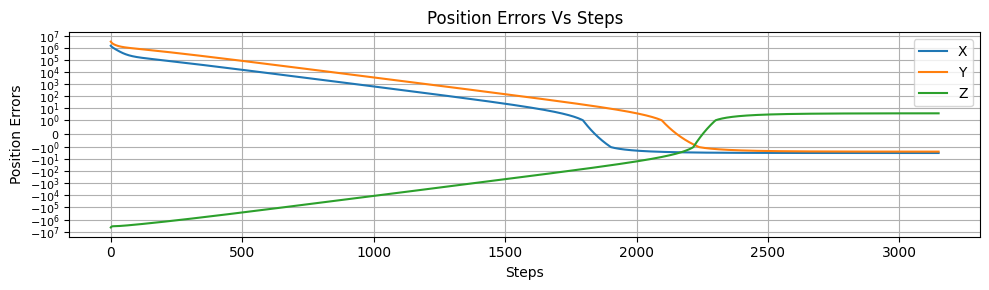

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# ...

# Plot each gradient with a label
ax.plot(arr_err[:], label=["X","Y","Z"])


# Set the y-axis to a symmetric logarithmic scale
ax.set_yscale('symlog', linthresh=1)
ax.set_xlabel("Steps", fontsize=10)
ax.set_ylabel("Position Errors", fontsize=10)
ax.set_title("Position Errors Vs Steps", fontsize=12)

# Customize the tick parameters on the y-axis
ax.tick_params(axis='y', labelsize=8)
# Display the legend
ax.legend()

ax.grid(True)
fig.tight_layout()
plt.show()


# Comment on the pattern
# Overall, the position error decrease smoothly, and both 3 have a sharp bend when the error is around 0.Then the downward trend stabilizes separately

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

Converged !
lr=0.01
[-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46482723e+00]
[-3.06248086 -2.3467329   3.77276552]
29763
6.197837646445273
[ 0.00014976  0.00083446 -0.00256463 -0.00145396]


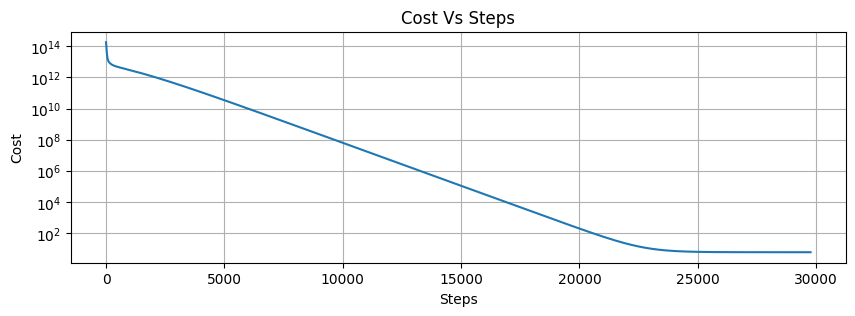

In [127]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0


optimized_params_2 = gradient_descent(pseudorange, sat_pos,learning_rate=0.01,max_iters=10000000)

# print the mentioned metrics
print("lr=0.01")
print(optimized_params)
print(arr_err[-1])
print(steps_count)
print(arr_cost[-1])
print(arr_grad[-1])


fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.semilogy(arr_cost)
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Cost Vs Steps")
ax.grid(True)
#fig.tight_layout()
plt.show()


# ...

Converged !
lr=0.001
[-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46482723e+00]
[-3.05743569 -2.31862133  3.6863669 ]
279686
6.20504954654009
[ 0.00046981  0.00261779 -0.00804556 -0.00456126]


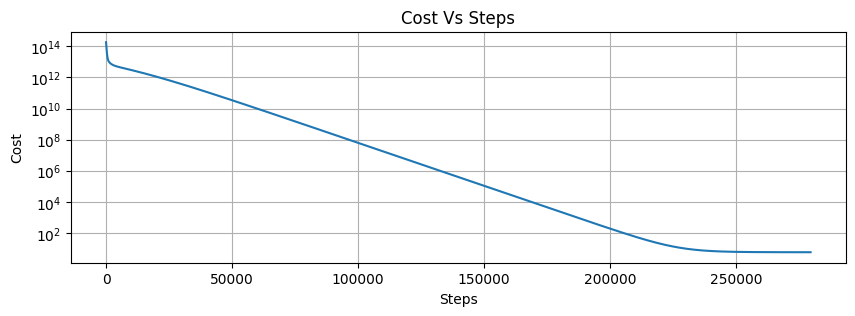

In [128]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos,learning_rate=0.001,max_iters=1000000)

# print the mentioned metrics
print("lr=0.001")
print(optimized_params)
print(arr_err[-1])
print(steps_count)
print(arr_cost[-1])
print(arr_grad[-1])


fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.semilogy(arr_cost)
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Cost Vs Steps")
ax.grid(True)
#fig.tight_layout()
plt.show()
# ...

## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)


Q1: It takes much longer time and more steps to converge if you lower down the learning rate.(For 0.01 is about 25000 steps;For 0.001 is about 250000 steps)
Q2: For least square methods, it is much more computational efficient.
LSE provides an exact solution for the parameters when the problem has a closed-form solution.Gradient Descent provides an approximate solution that can be very close to the minimum of the objective function, but it may not reach an exact solution depending on factors like the learning rate, number of iterations, and convergence criteria.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# Data (as pandas dataframes) (1 mark)
#Feature matrix, X
df = pd.DataFrame(phishing_websites.data.features)
X=df
#Target vector, y
df['Result'] = phishing_websites.data.targets
y=df['Result']

# Display sizes of X and y (1 mark)
print("Size of X:", X.size) #size of X (features)
print("Size of y:", y.size) #size of y (target)


Size of X: 342705
Size of y: 11055


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

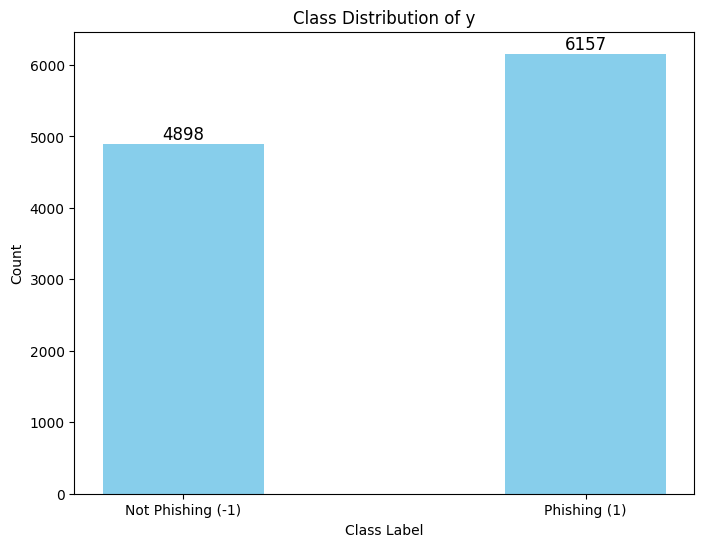

In [ ]:
#Class distribution of y (2 mark)
unique, counts = np.unique(y, return_counts=True) #count of -1 and 1
class_counts = dict(zip(unique, counts)) #pairing class labels and respective count

#Histogram plot
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', tick_label=["Not Phishing (-1)", "Phishing (1)"])

# Display exact values for each bin in the histogram
for bar, count in zip(bars, class_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1,
             f'{count}', ha='center', va='bottom', fontsize=12, color='black')


plt.title('Class Distribution of y')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# sklearn import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Smaller dataset with 3% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.97, random_state=42)
X_small = X_train
y_small = y_train

# Sizes of X_small and y_small (2 mark)
print(X_small.size)
print(y_small.size)

10261
331


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

"Step 3"
# sklearn logistic regression import
from sklearn.linear_model import LogisticRegression

# datasets
# X and y
X_full=X #X
y_full=y #y

# First two columns of X and y
X_two=X.iloc[:,:2] #first two columns of X

# X_small and y_small
X_small=X_train #X_small
y_small=y_train #y_small

# Instantiate model with X and y
model_full = LogisticRegression(max_iter=2000)
model_full.fit(X_full, y_full)

# Instantiate model with first two columns of X
model_two = LogisticRegression(max_iter=2000)
model_two.fit(X_two, y_full)

# Instantiate model with X_small and y_small
model_small = LogisticRegression(max_iter=2000)
model_small.fit(X_small, y_small)

"Step 4"
# X and y full 1-6:
# 1. data size
print(f"X_full data size: {X_full.size}")
print(f"y_full data size: {y_full.size}")


# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



X_full data size: 342705
y_full data size: 11055


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---